## Realistic features - to scale, in target coordinates

In [1]:
# import packages
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
from scipy import special

# switch on inline plotting
%matplotlib inline

# append path for loading own packages
import sys
sys.path.append("../packages")

# import own packages
import edges
import grating
import copy
from auxiliary import theta
from auxiliary import evp
from auxiliary import transpose_extent
import auxiliary as aux
import jitter
import density
import imaging as imgg
from imaging import expand_coordinates
from running import *

# Measures / parameter set

**pitch**: Horizontal feature pattern length (50 nm, 100 nm, 400 nm)

**hfs**: Horizontal feature size (measured half height to half height, always 50 % of *pitch*)

**vfs**: Vertical feature size (measured from asymptotic bottom to asymptotic top, same as *hfs*)

In [2]:
params = {}

# Amplitude of jitter
params['jitter_amplitude'] = 0e-9

# Focus size (edge length) in m
params['focus_size'] = 2e-6

# Definitions: Laser coordinate range and resolution
params['xres'] = 1024
params['yres'] = 1024
params['zres'] = 64

# Smoothing
params['nsigma']  = 2


pitches =            [100e-9, 400e-9]
jitter_wavelengths = [50e-9]
sigmas =             [0e-9]
tilts =              [0/180*np.pi, 30/180*np.pi]
edge_angles =        [0, 30/180*np.pi]
edge_types =         ['skewededge',]

# Define behavior
params['calc3d'] = False
params['only_count'] = False
params['validation_plot'] = True
params['save_summed_density'] = True
params['summed_density_plot'] = True
params['outdir'] = "../results/Scan8_Test"

# 3D density of silicon in electrons per m^3
dens3_silicon = 7e29

# 3D density of grating in electrons per m^3
params['dens3_grating'] = dens3_silicon

# 3D density of foil (without grating) in electrons per m^3
params['dens3_foil'] = dens3_silicon

# Number of electrons in a cell of full density
params['nelectrons'] = 1
#params['nelectrons'] = lambda :\
#    (evp(params['xmax']) - evp(params['xmin'])) / evp(params['xres']) *\
#    (evp(params['ymax']) - evp(params['ymin'])) / evp(params['yres']) *\
#    (evp(params['zmax']) - evp(params['zmin'])) / evp(params['zres']) *\
#     evp(params['dens3_foil'])

In [3]:
# Horizontal feature size
def hfs_from_pitch(pitch, alpha):
    return alpha * pitch

# Vertical feature size
def vfs_from_pitch(pitch, alpha):
    return alpha * pitch

def foil_thick_from_vfs(vfs):
    return vfs

def edge_width_from_vfs_etc(vfs, angle):
    return np.tan(angle) * vfs

def edge_from_edge_width_etc(edge_width, vfs, name):
    if name == 'skewededge':
        return Edge(edges.make_skewed_edge(edge_width, vfs), name)


# Laser coordinate range
def xmin_from_focus_size(focus_size):
    return -0.5 * focus_size

def xmax_from_focus_size(focus_size):
    return  0.5 * focus_size

def ymin_from_focus_size(focus_size):
    return -0.5 * focus_size

def ymax_from_focus_size(focus_size):
    return  0.5 * focus_size

def zmin_from_focus_size_etc(focus_size, vfs):
    return -0.5 * focus_size - np.sqrt(2) * 1.5 * vfs

def zmax_from_focus_size_etc(focus_size, foil_thick):
    return  0.5 * focus_size + np.sqrt(2) * 1.5 * foil_thick


# Laser coordinate extents (for plotting)
def extent_laser_xy(xmin, xmax, ymin, ymax):
    return [xmin, xmax, ymin, ymax]

def extent_laser_xz(xmin, xmax, zmin, zmax):
    return [xmin, xmax, zmin, zmax]

def extent_laser_yz(ymin, ymax, zmin, zmax):
    return [ymin, ymax, zmin, zmax]


# Target coordinate range
def xpmin_from_xmax(xmax):
    return aux.rcoords2tcoords(xmax, 0, 0)[0]

def xpmax_from_xmin(xmin):
    return aux.rcoords2tcoords(xmin, 0, 0)[0]

def ypmin_from_ymin(ymin):
    return aux.rcoords2tcoords(0, ymin, 0)[1]

def ypmax_from_ymax(ymax):
    return aux.rcoords2tcoords(0, ymax, 0)[1]

def zpmin_from_zmax(zmax):
    return aux.rcoords2tcoords(0, 0, zmax)[2]

def zpmax_from_zmin(zmin):
    return aux.rcoords2tcoords(0, 0, zmin)[2]


# Smoothing
def sigmaxp_from_sigma(sigma):
    return sigma

def sigmayp_from_sigma(sigma):
    return sigma

def sigmax_from_sigmaxp(sigmaxp):
    return np.sqrt(2)*sigmaxp

def sigmay_from_sigmayp(sigmayp):
    return sigmayp

def pixelsize_from_xmax_etc(xmax, xmin, xres):
    return (xmax-xmin)/xres

def kernelx_from_sigmax_etc(sigmax, pixelsize, nsigma):
    return imgg.gaussian_kernel(sigmax, 0, pixelsize, nsigma)

def kernely_from_sigmay_etc(sigmay, pixelsize, nsigma):
    return imgg.gaussian_kernel(0, sigmay, pixelsize, nsigma)

1
000nm-edgewidth_skewededge-edgetype_100nm-pitch_000nm-jampl_050nm-jwl_000nm-sigma_000deg-tilt_000deg-edgeangle
x.size: 1024
y.size: 1024
kernelx_size: 1
kernely_size: 1
xnew.size: 1024
ynew.size: 1024
CPU times: user 25.2 s, sys: 2.44 s, total: 27.6 s
Wall time: 27.9 s

2
029nm-edgewidth_skewededge-edgetype_100nm-pitch_000nm-jampl_050nm-jwl_000nm-sigma_000deg-tilt_030deg-edgeangle
x.size: 1024
y.size: 1024
kernelx_size: 1
kernely_size: 1
xnew.size: 1024
ynew.size: 1024
CPU times: user 29.1 s, sys: 2.93 s, total: 32.1 s
Wall time: 32.3 s

3
000nm-edgewidth_skewededge-edgetype_100nm-pitch_000nm-jampl_050nm-jwl_000nm-sigma_030deg-tilt_000deg-edgeangle
x.size: 1024
y.size: 1024
kernelx_size: 1
kernely_size: 1
xnew.size: 1024
ynew.size: 1024
CPU times: user 25.3 s, sys: 2.96 s, total: 28.3 s
Wall time: 28.5 s

4
029nm-edgewidth_skewededge-edgetype_100nm-pitch_000nm-jampl_050nm-jwl_000nm-sigma_030deg-tilt_030deg-edgeangle
x.size: 1024
y.size: 1024
kernelx_size: 1
kernely_size: 1
xnew.size:

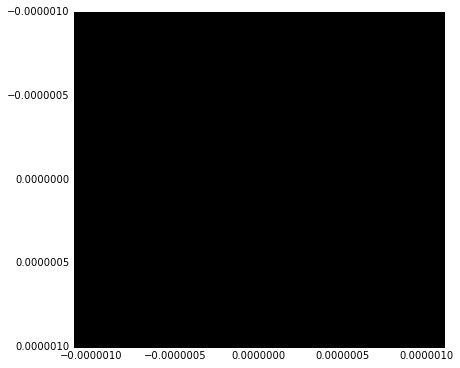

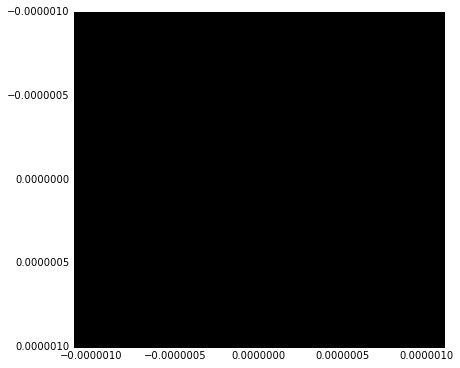

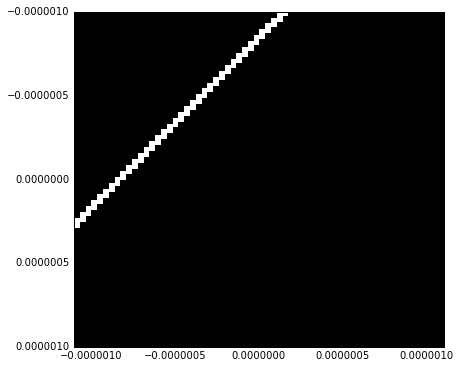

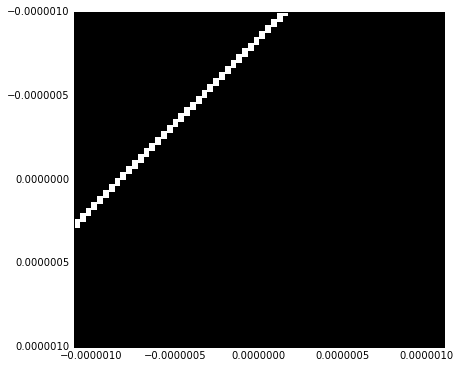

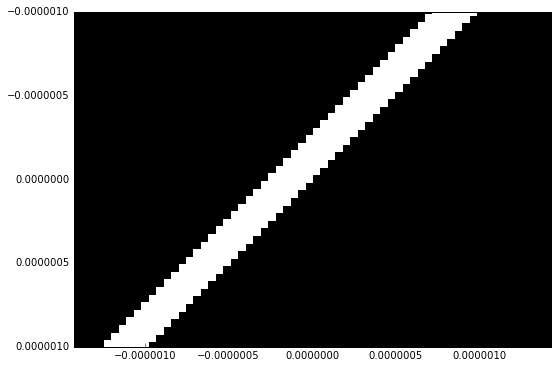

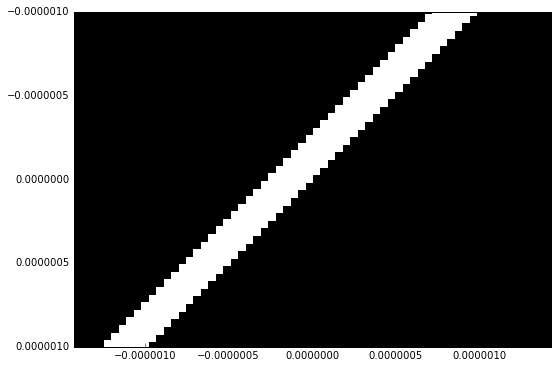

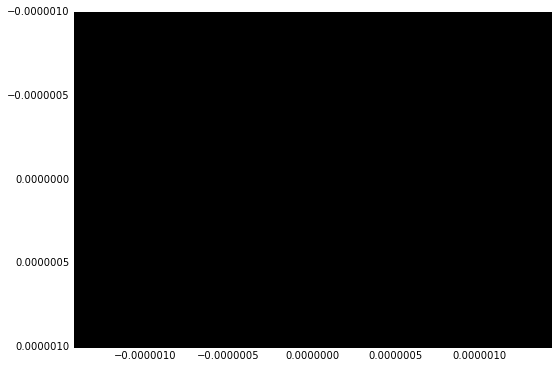

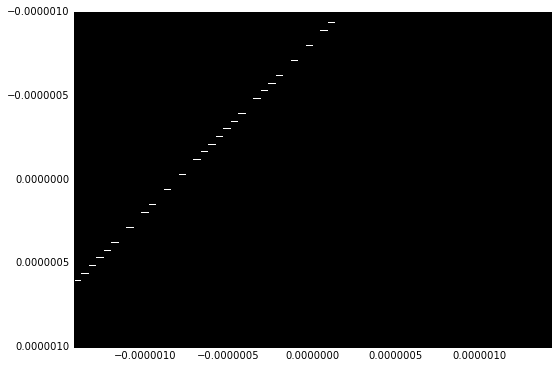

In [4]:
# Run parameter scan
import itertools

scanlist   = [pitches, jitter_wavelengths, sigmas, edge_types, tilts, edge_angles]

def unpack_scantuple(params, t):
    # Extract scan case parameters
    params['pitch'] = t[0]
    params['jitter_wavelength'] = t[1]
    params['sigma'] = t[2]
    params['edge_type'] = t[3]
    params['tilt'] = t[4]
    params['edge_angle'] = t[5]
    
    # Calculate dependent parameters
    params['hfs'] =        hfs_from_pitch(params['pitch'], 0.5)
    params['vfs'] =        vfs_from_pitch(params['pitch'], 0.5)
    params['edge_width'] = edge_width_from_vfs_etc(params['vfs'], params['edge_angle'])
    params['foil_thick'] = foil_thick_from_vfs(params['vfs'])
    params['edge'] =       edge_from_edge_width_etc(params['edge_width'], params['vfs'], params['edge_type'])
    
    params['xmin'] =       xmin_from_focus_size(params['focus_size'])
    params['xmax'] =       xmax_from_focus_size(params['focus_size'])
    params['ymin'] =       ymin_from_focus_size(params['focus_size'])
    params['ymax'] =       ymax_from_focus_size(params['focus_size'])
    params['zmin'] =       zmin_from_focus_size_etc(params['focus_size'], params['vfs'])
    params['zmax'] =       zmax_from_focus_size_etc(params['focus_size'], params['foil_thick'])
    
    params['extent_laser_xy'] = extent_laser_xy(params['xmin'], params['xmax'], params['ymin'], params['ymax'])
    params['extent_laser_xz'] = extent_laser_xy(params['xmin'], params['xmax'], params['zmin'], params['zmax'])
    params['extent_laser_yz'] = extent_laser_xy(params['ymin'], params['ymax'], params['zmin'], params['zmax'])

    params['xpmin'] =      xpmin_from_xmax(params['xmax'])
    params['xpmax'] =      xpmax_from_xmin(params['xmin'])
    params['ypmin'] =      ypmin_from_ymin(params['ymin'])
    params['ypmax'] =      ypmax_from_ymax(params['ymax'])
    params['zpmin'] =      zpmin_from_zmax(params['zmax'])
    params['zpmax'] =      zpmax_from_zmin(params['zmin'])

    params['sigmaxp'] =    sigmaxp_from_sigma(params['sigma'])
    params['sigmayp'] =    sigmayp_from_sigma(params['sigma'])
    params['sigmax'] =     sigmax_from_sigmaxp(params['sigmaxp'])
    params['sigmay'] =     sigmay_from_sigmayp(params['sigmayp'])
    params['pixelsize'] =  pixelsize_from_xmax_etc(params['xmax'], params['xmin'], params['xres'])
    params['kernelx'] =    kernelx_from_sigmax_etc(params['sigmax'], params['pixelsize'], params['nsigma'])
    params['kernely'] =    kernely_from_sigmay_etc(params['sigmay'], params['pixelsize'], params['nsigma'])
    
count = 0
for scantuple in itertools.product(*scanlist):
    unpack_scantuple(params, scantuple)

    # Make 1D laser coordinate arrays
    params['x']  = np.linspace(params['xmin'],  params['xmax'],  params['xres'])
    params['y']  = np.linspace(params['ymin'],  params['ymax'],  params['yres'])
    params['z']  = np.linspace(params['zmin'],  params['zmax'],  params['zres'])
    
    # Make 1D target coordinate arrays
    params['xp'] = np.linspace(params['xpmin'], params['xpmax'], params['xres'])
    params['yp'] = np.linspace(params['ypmin'], params['ypmax'], params['yres'])
    params['zp'] = np.linspace(params['zpmin'], params['zpmax'], params['zres'])

    count += 1
    print(count)
    if not params['only_count']:
        %time run(**params)
        
        print("")

print("Number of cases: {}".format(count))

Strange behavior - x and y axes seem swapped in the 3D array (?!)